In [1]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from keras.datasets import mnist

from google.colab import output

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


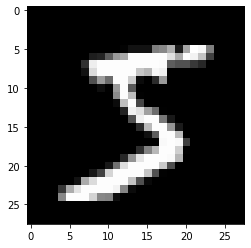

Label: 5
Flatten size: 784


In [4]:
pyplot.imshow(train_X[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print("Label: {}".format(train_y[0]))
print("Flatten size: {}".format(len(train_X[0].flatten())))

In [5]:
%mkdir results

In [6]:
!git clone https://github.com/PauliusMilmantas/Bakalaurinis_darbas

Cloning into 'Bakalaurinis_darbas'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 226 (delta 111), reused 178 (delta 63), pack-reused 0
Receiving objects: 100% (226/226), 2.54 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [7]:
%cd /content/Bakalaurinis_darbas/Code

/content/Bakalaurinis_darbas/Code


In [8]:
def get_answer(output):
  maxVal = -100
  maxIdx = -1

  for i in range(9):
    if output[i] > maxVal:
      maxVal = output[i]
      maxIdx = i

  return maxIdx

In [9]:
import pandas as pd

class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root
    self.data = pd.read_csv(root)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    dat = {}
    dat['Pregnancies'] = self.data['Pregnancies'][idx]
    dat['Glucose'] = self.data['Glucose'][idx]
    dat['BloodPressure'] = self.data['BloodPressure'][idx]
    dat['BMI'] = self.data['BMI'][idx]
    dat['Age'] = self.data['Age'][idx]
    found_type = self.data['Outcome'][idx]

    return {'data': dat, 'class_name': found_type}

class MNISTDataset(Dataset):
  def __init__(self, root):
    self.root = root
    self.data = { "train_X": train_X, "train_y": train_y, "test_X": test_X, "test_y": test_y }

  def __len__(self):
    if self.root == 'test':
      return len(self.data["test_X"])
    else:
      return len(self.data["train_X"])

  def __getitem__(self, idx):
    if self.root == 'test':
      return {'data': test_X[idx], 'class_name': test_y[idx]}
    else:
      return {'data': train_X[idx], 'class_name': train_y[idx]}

train_dataset = MNISTDataset('test')
test_dataset = MNISTDataset('train')

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

2 <- 7 <- 15 <- 5

In [11]:
network = Net(784, 394, 196, 10)
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=784, out_features=394, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=394, out_features=196, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=196, out_features=10, bias=True)
)


In [12]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cpu')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset),shuffle=True)

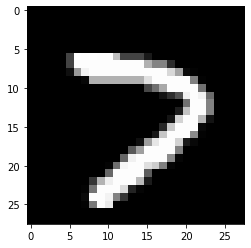

tensor(7, dtype=torch.uint8)


In [15]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
dat = itr['data']

pyplot.imshow(dat[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

print(label[0])

In [16]:
def train(train_loader, test_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  acc_history = []

  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_data_train = 0

    # TRAINING DATASET
    correct = 0
    wrong = 0
    for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      lossSum = 0

      for idx in range(len(labels)):
        optimizer.zero_grad()
        
        outputs = network(torch.Tensor(dat[idx].flatten().float()))
        realAnswer = np.zeros(10)
        realAnswer[labels[idx]] = 1

        loss = criterion(outputs, torch.Tensor(realAnswer))
          
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()
    
    # TESTING DATASET
    for data in test_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(dat[idx].flatten().float()))

        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        if predicted == real_answer:
          correct += 1
        else:
          wrong += 1

    acc_history.append(
        correct/(correct+wrong)*100
    )
    
    print("Epoch: {} Training loss: {} Accuracy: {}".format(epoch,train_loss_hist[len(train_loss_hist) - 1], acc_history[len(acc_history) - 1]))
    #print("Epoch: {} Training loss: {}".format(epoch,train_loss_hist[len(train_loss_hist) - 1]))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

  plt.plot(np.arange(0, len(train_loss_hist), 1), train_loss_hist)
  plt.show()

  plt.plot(np.arange(0, len(acc_history), 1), acc_history)
  plt.show()

  avg_hist = []

  for i in range(int(len(acc_history)/10)):
    avg = 0
    
    for p in range(10):
      avg += acc_history[i*10 + p]

    avg_hist.append(avg/10)

  plt.plot(np.arange(0, len(avg_hist)), avg_hist)
  plt.grid()
  plt.show()

train(train_loader, test_loader, 30)


Epoch: 0 Training loss: 1903.2614554490428 Accuracy: 21.346666666666668
Epoch: 1 Training loss: 815.8818936089228 Accuracy: 31.511666666666667
Epoch: 2 Training loss: 740.0499005436905 Accuracy: 41.845
Epoch: 3 Training loss: 638.3918827560165 Accuracy: 46.95333333333333
Epoch: 4 Training loss: 589.6812665445523 Accuracy: 47.94
Epoch: 5 Training loss: 570.4828443628357 Accuracy: 50.035
Epoch: 6 Training loss: 513.7675645543904 Accuracy: 62.08166666666667
Epoch: 7 Training loss: 412.94467111402446 Accuracy: 73.52
Epoch: 8 Training loss: 346.82017706565057 Accuracy: 76.26666666666667
Epoch: 9 Training loss: 326.4756748134314 Accuracy: 77.84833333333333
Epoch: 10 Training loss: 313.17249779902886 Accuracy: 78.66
Epoch: 11 Training loss: 302.0557221195959 Accuracy: 79.34166666666667
Epoch: 12 Training loss: 292.61267280345055 Accuracy: 80.015
Epoch: 13 Training loss: 283.95644711106434 Accuracy: 80.325
Epoch: 14 Training loss: 276.4095507735774 Accuracy: 80.88166666666666
Epoch: 15 Trainin

KeyboardInterrupt: ignored

Palieka tik tie duomenys iš training_set, kurie yra teisingai atsakyti

In [19]:
increaseValues = np.zeros(len(train_dataset))
dataIdx = np.zeros(len(train_dataset))

calculatedIdx = 0
prevPercent = 0
for data in train_loader:
      labels = torch.from_numpy(np.array(data['class_name']))
      dat = data['data']

      for idx in range(len(labels)):
        outputs = network(torch.Tensor(dat[idx].flatten().float()))

        predicted = get_answer(outputs)
        real_answer = labels[idx].item()

        collumnIdx = 0
        for collumnIdx in range(5):

          # Sutampa duomenys, vykdoma tolimesne analize
          if(predicted == real_answer):
            epsilon = 1
            increase = 0
            dataIdx[collumnIdx] += 1

            while(predicted == real_answer and increase < 100):
              tempData = dat[idx].flatten().float()
              increase += epsilon
              tempData[0] += increase

              outputs = network(torch.Tensor(tempData))

              predicted = get_answer(outputs)
              real_answer = labels[idx].item()

            increaseValues[collumnIdx] += increase

        calculatedIdx += 1
        if calculatedIdx*100/len(train_dataset) != prevPercent:
          prevPercent = calculatedIdx*100/len(train_dataset)
          print("{}%".format(prevPercent))

for i in range(len(train_dataset)):
  if dataIdx[i] == 0:
    dataIdx[i] = 1

  print("{}th collumn maximum epsilon: {}".format(i, increaseValues[i]/dataIdx[i]))

s = 0
for i in range(len(train_dataset)):
  s += increaseValues[i]/dataIdx[i]

print("Model maximum epsilon: {}".format(s/len(train_dataset)))

Streaming output truncated to the last 5000 lines.
5001th collumn maximum epsilon: 0.0
5002th collumn maximum epsilon: 0.0
5003th collumn maximum epsilon: 0.0
5004th collumn maximum epsilon: 0.0
5005th collumn maximum epsilon: 0.0
5006th collumn maximum epsilon: 0.0
5007th collumn maximum epsilon: 0.0
5008th collumn maximum epsilon: 0.0
5009th collumn maximum epsilon: 0.0
5010th collumn maximum epsilon: 0.0
5011th collumn maximum epsilon: 0.0
5012th collumn maximum epsilon: 0.0
5013th collumn maximum epsilon: 0.0
5014th collumn maximum epsilon: 0.0
5015th collumn maximum epsilon: 0.0
5016th collumn maximum epsilon: 0.0
5017th collumn maximum epsilon: 0.0
5018th collumn maximum epsilon: 0.0
5019th collumn maximum epsilon: 0.0
5020th collumn maximum epsilon: 0.0
5021th collumn maximum epsilon: 0.0
5022th collumn maximum epsilon: 0.0
5023th collumn maximum epsilon: 0.0
5024th collumn maximum epsilon: 0.0
5025th collumn maximum epsilon: 0.0
5026th collumn maximum epsilon: 0.0
5027th collum